In [5]:
# conda activate /home/zhengweiguo/miniconda3/envs/lcj_bert
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from binary_io import *
import json
import os

dataset = 'imagenet'
dataset = 'gist1m'
dataset = 'wikipedia'
config = json.loads(open('config.json').read())
M, efs = config[dataset]["M"], config[dataset]["efs"]
efc = 1000
ck_ts = 2000
k = 1000
threshold = 999

data_prefix = '/data/disk1/liuchengjun/HNNS/sample/'
checkpoint_prefix = '/data/disk1/liuchengjun/HNNS/checkpoint/'
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}'
checkpoint_path = f'{checkpoint_prefix}{prefix}.thr_{threshold}.txt'

train_feature = fvecs_read(f'{data_prefix}{prefix}.train_feats_nn.fvecs')
train_recall_number = ivecs_read(f'{data_prefix}{prefix}.train_label.ivecs')[:, 0]
train_label = train_recall_number < threshold
train_comps = ivecs_read(f'{data_prefix}{prefix}.train_label.ivecs')[:, 1]
test_feature = fvecs_read(f'{data_prefix}{prefix}.test_feats_nn.fvecs')
test_recall_number = ivecs_read(f'{data_prefix}{prefix}.test_label.ivecs')[:, 0]
test_label = test_recall_number < threshold
test_comps = ivecs_read(f'{data_prefix}{prefix}.test_label.ivecs')[:, 1]

# print(len(train_feature), len(train_label))
print(np.sum(test_label), np.sum(train_label))
# print(len(train_feature[0]), train_feature[0][-101:])


3374 173256


In [6]:
params = {
    'boosting_type': 'gbdt',    # 使用 GBDT 算法
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss',            # 使用 binary_logloss 作为评估指标
    'learning_rate': 0.05,       # 学习率
    'num_boost_round': 3000,     # 提升迭代的轮数
    'verbose': 1,               # 控制处理信息的详细程度
    'num_threads': 128           # 设置线程数
}

In [7]:
if os.path.exists(checkpoint_path):
    print(f'[Checkpoint] {checkpoint_path} exist!')
    gbm = lgb.Booster(model_file = checkpoint_path)
    print('[Checkpoint] Loaded!')
else:
    print(f'[Checkpoint] {checkpoint_path} not exist!')
    print('[Checkpoint] Training!')
    gbm = lgb.train(params, lgb.Dataset(train_feature, label=train_label))
    gbm.save_model(checkpoint_path)
    print('[Checkpoint] Done!')

train_pred = gbm.predict(train_feature)
pct50 = np.median(train_pred)
print(f'pct50 threshold: {pct50}')


[Checkpoint] /data/disk1/liuchengjun/HNNS/checkpoint/wikipedia.M_128.efc_1000.efs_3000.ck_ts_2000.ncheck_100.recall@1000.thr_999.txt exist!
[Checkpoint] Loaded!
pct50 threshold: 0.17796093738341967


Area Under the Curve (AUC): 0.7795643153526971


PermissionError: [Errno 13] Permission denied: '/home/zhengweiguo/liuchengjun/HybridNNS/script/wikipedia.M_128.efc_1000.efs_3000.ck_ts_2000.ncheck_100.recall@1000.thr_999.png'

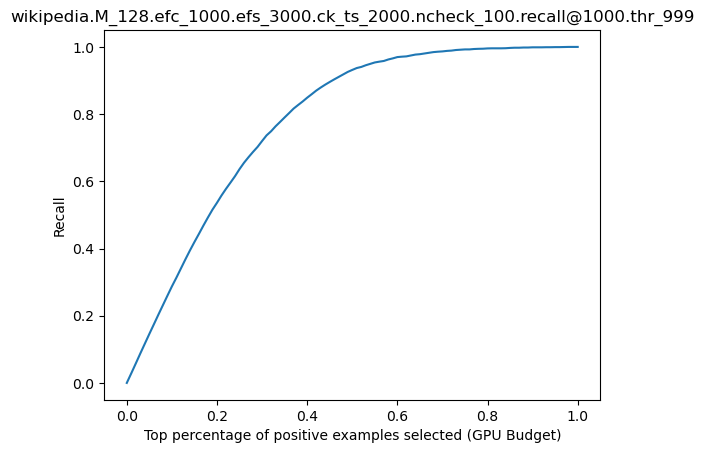

In [8]:
from sklearn.metrics import recall_score
import time
import numpy as np
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz

start = time.time()
label_pred = gbm.predict(test_feature)
end = time.time()

def recall_curve(test_label, label_pred):
    n = len(label_pred)
    recalls = []
    percentages = np.arange(0, 1.01, 0.01)  # 从0%到100%，步长为1%
    for p in percentages:
        threshold = np.percentile(label_pred, 100 * (1 - p))
        if p==0: threshold += 1
        new_label_pred = np.where(label_pred >= threshold, 1, 0)
        recall = recall_score(test_label, new_label_pred)
        recalls.append(recall)
    return percentages, recalls

percentages, recalls = recall_curve(test_label, label_pred)
auc = trapz(recalls, percentages)
print("Area Under the Curve (AUC):", auc)

total_true_label = np.sum(test_label)
step = 2
for p in range(0, 100 + step, step):
    fail = total_true_label * (1 - recalls[p])
    success = len(test_label) - fail
    overall_recall = (success * 1.000 + fail * 0.997) / len(test_label)
    # print(f'{p}%->bruteforce | predict recall: {recalls[p]:4f} | overall recall: {overall_recall:6f}')

plt.plot(percentages, recalls)
plt.xlabel("Top percentage of positive examples selected (GPU Budget)")
plt.ylabel("Recall")
fig_path = f'{prefix}.thr_{threshold}'
plt.title(fig_path)
plt.savefig(fig_path + '.png', dpi=300)
plt.show()

train_recall_number_mn = np.min(train_recall_number)
hist, bins = np.histogram(train_recall_number, bins = range(0, 1000 + 1))
plt.bar(bins[: -1], hist, width = 1)
plt.xlabel('train_recall_number')
plt.xlim([train_recall_number_mn - 10, 1000])
plt.ylim(0.1)
plt.yscale('log')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of train_recall_number')
print(f'train_recall_number_mn: {train_recall_number_mn}')
fig_path = f'{prefix}.recall_hist'
plt.savefig(fig_path + '.png', dpi=300)
plt.show()

plt.clf()
# plt.scatter(x = train_recall_number, y = train_comps, s=1)
train_comps = train_comps[train_recall_number >= 950]
train_recall_number = train_recall_number[train_recall_number >= 950]
heatmap, xedges, yedges = np.histogram2d(train_recall_number, train_comps, bins=50)
heatmap = np.log(heatmap + 1)

plt.imshow(heatmap.T, origin = 'lower', extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect = 'auto', cmap = 'viridis')

plt.xlabel('train_recall_number')
plt.ylabel('train_comps')
# plt.xscale('log')
# plt.xlim([990, 1000])
ax = plt.gca()
ax.invert_xaxis()
plt.title('Scatter Plot of train_recall_number vs train_comps')
plt.colorbar()
fig_path = f'{prefix}.Comp_R'
plt.savefig(fig_path + '.png', dpi=300)
plt.show()
for R in range(950, 1001):
    print(f'avg comparison for {R/1000}: {np.mean(train_comps[train_recall_number == R]):.2f}')
